In [1]:
project_id = 'elife-data-pipeline'
source_dataset = 'de_dev'
output_dataset = 'de_dev'
output_table_prefix = 'data_science_'

max_workers = 10
max_manuscripts = 50000
email = 'd.ecer@elifesciences.org'

In [2]:
import json
import re
import os
import logging
from datetime import datetime
from functools import partial
from concurrent.futures import ThreadPoolExecutor 
from typing import List

import numpy as np
import pandas as pd
import requests
from tqdm.auto import tqdm

import google.cloud.exceptions

import data_science_pipeline.configure_warnings

from data_science_pipeline.sql import get_sql
from data_science_pipeline.utils.europepmc import (
    EUROPEPMC_MAX_PAGE_SIZE,
    EuropePMCApi,
    europepmc_requests_retry_session
)
from data_science_pipeline.utils.misc import iter_batches
from data_science_pipeline.utils.bq import (
    is_bq_not_found_exception,
    load_json_list_and_append_to_bq_table_with_auto_schema
)
from data_science_pipeline.utils.pandas import read_csv
from data_science_pipeline.utils.jupyter import (
    read_big_query as _read_big_query,
)

In [3]:
LOGGER = logging.getLogger(__name__)

logging.basicConfig(level='INFO')
# logging.getLogger('data_science_pipeline.utils.bq').setLevel(logging.DEBUG)

In [4]:
editor_parsed_pubmed_ids_table_name = '{output_dataset}.{prefix}{suffix}'.format(
    output_dataset=output_dataset,
    prefix=output_table_prefix,
    suffix='editor_pubmed_ids'
)

external_manuscript_summary_output_table_name = '{output_dataset}.{prefix}{suffix}'.format(
    output_dataset=output_dataset,
    prefix=output_table_prefix,
    suffix='external_manuscript_summary'
)

In [5]:
read_big_query = partial(_read_big_query, project_id=project_id)

In [6]:
_sql = (
    'SELECT pmid FROM `{table}`'
).format(table=external_manuscript_summary_output_table_name)

try:
    existing_pmids_df = read_big_query(_sql)
except Exception as e:
    if not is_bq_not_found_exception(e):
        raise
    print('table not found: %s', external_manuscript_summary_output_table_name)
    existing_pmids_df = pd.DataFrame(columns=['pmid'])
print(len(existing_pmids_df))
existing_pmids_df.head()

> ```sql
> SELECT pmid FROM `de_dev.data_science_external_manuscript_summary`
> ```

Downloading: 100%|██████████| 92907/92907 [00:02<00:00, 42264.19rows/s]

92907


,pmid
0,20967591
1,23159048
2,15974877
3,15974877
4,15974877


In [7]:
existing_pmids_df.dtypes

pmid    object
dtype: object

In [8]:
existing_pmids_set = set(existing_pmids_df['pmid'])
len(existing_pmids_set)

89910

In [9]:
_sql = '\n'.join([
    'SELECT person_id, name, pubmed_url, pubmed_ids',
    'FROM `{table}`'
]).format(table=editor_parsed_pubmed_ids_table_name)

editor_pubmed_ids_df = read_big_query(_sql)
print(len(editor_pubmed_ids_df))
editor_pubmed_ids_df.head()

> ```sql
> SELECT person_id, name, pubmed_url, pubmed_ids
> FROM `de_dev.data_science_editor_pubmed_ids`
> ```

Downloading: 100%|██████████| 609/609 [00:07<00:00, 76.13rows/s] 
INFO:pandas_gbq.gbq:Total time taken 9.47 s.
Finished at 2020-06-17 12:45:42.


609


,person_id,name,pubmed_url,pubmed_ids
0,9032,David Ginty,http://www.ncbi.nlm.nih.gov/pubmed?term=Ginty%...,"[10900019, 11055433, 10493722, 11238898, 10600..."
1,19576,Barbara Shinn-Cunningham,http://www.ncbi.nlm.nih.gov/pubmed?term=Shinn-...,"[18164143, 11519579, 10738816, 11206163, 10573..."
2,1054,Axel Brunger,http://www.ncbi.nlm.nih.gov/pubmed?term=Brunge...,"[20448167, 20823553, 18425411, 11779506, 11226..."
3,1045,Dominique Bergmann,http://www.ncbi.nlm.nih.gov/pubmed?term=Bergma...,"[23444192, 11378445]"
4,117606,Amita Sehgal,https://www.ncbi.nlm.nih.gov/pubmed?term=Segha...,"[25294731, 17506830, 12827543]"


In [10]:
len(editor_pubmed_ids_df)

609

In [11]:
# check that the type is a proper list
editor_pubmed_ids_df['pubmed_ids'].values[0][:10]

['10900019',
 '11055433',
 '10493722',
 '11238898',
 '10600750',
 '10433267',
 '10707970',
 '9856463',
 '9836643',
 '9856475']

In [12]:
editor_pubmed_ids_df['pubmed_count'] = editor_pubmed_ids_df['pubmed_ids'].apply(len)
print((editor_pubmed_ids_df['pubmed_count'] >= 1000).sum())
editor_pubmed_ids_df.sort_values('pubmed_count', ascending=False).head(10)

62


,person_id,name,pubmed_url,pubmed_ids,pubmed_count
569,62806,Yue Wang,http://www.ncbi.nlm.nih.gov/pubmed?term=Wang%2...,"[32458900, 32441732, 32426795, 32426772, 32400...",154031
568,102717,Xiaochen Wang,https://www.ncbi.nlm.nih.gov/pubmed/?term=Wang...,"[32458900, 32421136, 32406443, 32383726, 32364...",111246
275,46040,Hong Zhang,http://www.ncbi.nlm.nih.gov/pubmed/?term=Zhang...,"[32462161, 32432257, 32412570, 32392273, 32400...",68973
470,90633,Lu Chen,https://www.ncbi.nlm.nih.gov/pubmed/?term=Chen...,"[32459254, 32396585, 32377651, 32373815, 32364...",49662
157,1309,Wenhui Li,http://www.ncbi.nlm.nih.gov/pubmed?term=Li%20W...,"[32459256, 32420568, 32390016, 32401260, 32400...",44206
366,90454,Jian Xu,https://www.ncbi.nlm.nih.gov/pubmed?term=Xu%20...,"[32391821, 32369096, 32355941, 32352466, 32352...",36445
266,4727,Mingjie Zhang,https://www.ncbi.nlm.nih.gov/pubmed/?term=Zhan...,"[32400829, 32400781, 32356536, 32373807, 32352...",30826
553,10628,Daeyeol Lee,https://www.ncbi.nlm.nih.gov/pubmed/?term=Lee%...,"[32391824, 32370603, 32100613, 32050844, 31851...",27562
452,17103,Hao Yu,http://www.ncbi.nlm.nih.gov/pubmed?term=Yu%20H...,"[32391528, 32390026, 32373889, 32364198, 32365...",22191
458,145793,Yuting Ma,https://www.ncbi.nlm.nih.gov/pubmed/?term=Ma%2...,"[32406447, 32412558, 32374309, 32352105, 32285...",21949


In [13]:
print('editors with >= 1000 pubmed ids:\n%s' % '\n'.join(
    '- %s: %s' % (row['name'], row['pubmed_url'])
    for row in editor_pubmed_ids_df[editor_pubmed_ids_df['pubmed_count'] >= 1000].to_dict(orient='records')
))

editors with >= 1000 pubmed ids:
- Jiwon Shim: https://www.ncbi.nlm.nih.gov/pubmed/?term=Shim%20J%5BAuthor%5D&cauthor=true&cauthor_uid=29992947
- Mathieu Wolff: https://www.ncbi.nlm.nih.gov/pubmed/?term=Wolff%20M%5BAuthor%5D&cauthor=true&cauthor_uid=26400947
- Kunlin Wei: https://www.ncbi.nlm.nih.gov/pubmed/?term=Wei%20K%5BAuthor%5D&cauthor=true&cauthor_uid=25232107
- Duojia Pan: http://www.ncbi.nlm.nih.gov/pubmed?term=Pan%20D%5Bau%5D&orig_db=PubMed&cmd=search
- Xiaobing Shi: https://www.ncbi.nlm.nih.gov/pubmed?term=Shi%20X&orig_db=PubMed&cmd=search
- Ming Meng: https://www.ncbi.nlm.nih.gov/pubmed/?term=Meng%20M%5BAuthor%5D&cauthor=true&cauthor_uid=26505302
- Tony Hunter: http://www.ncbi.nlm.nih.gov/pubmed?term=Hunter%20T%5Bau%5D&orig_db=PubMed&cmd=search
- Jeannie Lee: http://www.ncbi.nlm.nih.gov/pubmed/?term=Lee%20JT%5BAuthor%5D&cauthor=true&cauthor_uid=26489649
- Wenhui Li: http://www.ncbi.nlm.nih.gov/pubmed?term=Li%20W%5Bau%5D&orig_db=PubMed&cmd=search
- Andreas Martin: https://www

In [14]:
editor_pubmed_ids_df[editor_pubmed_ids_df['pubmed_count'] < 1000]['pubmed_count'].mean()

166.77148080438758

In [15]:
editor_pubmed_ids_df[editor_pubmed_ids_df['pubmed_count'] < 1000]['pubmed_count'].median()

90.0

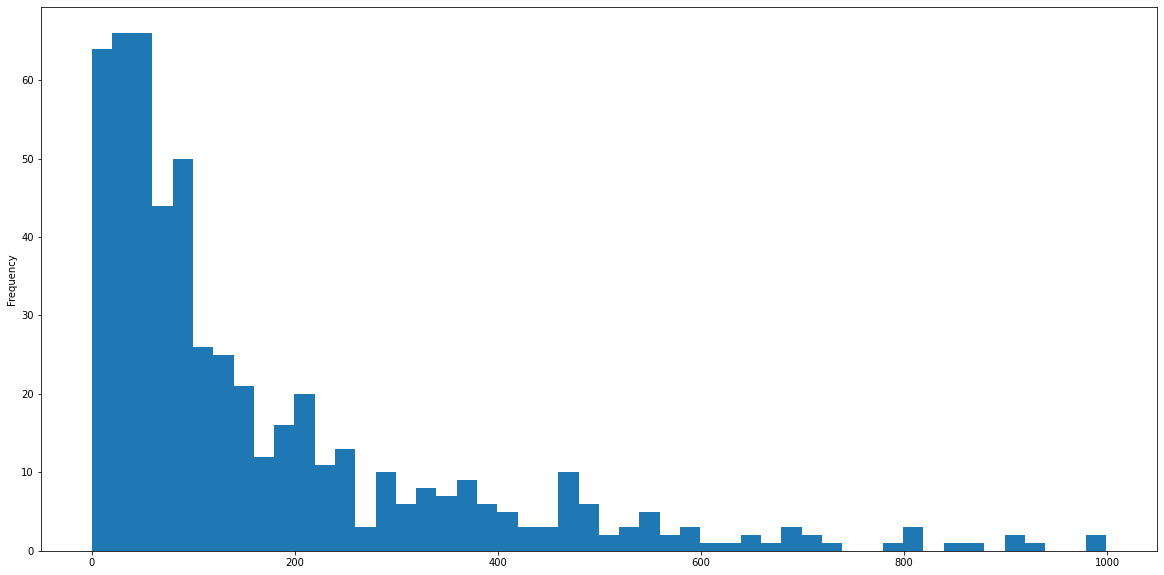

In [16]:
editor_pubmed_ids_df[editor_pubmed_ids_df['pubmed_count'] < 1000]['pubmed_count'].plot.hist(
    bins=50,
    figsize=(20, 10)
)
None

In [17]:
editor_clean_pubmed_ids_df = editor_pubmed_ids_df[editor_pubmed_ids_df['pubmed_count'] < 1000]
print(len(editor_clean_pubmed_ids_df))
editor_clean_pubmed_ids_df.sort_values('pubmed_count', ascending=False).head(10)

547


,person_id,name,pubmed_url,pubmed_ids,pubmed_count
290,53174,Katalin Toth,https://www.ncbi.nlm.nih.gov/pubmed/?term=T%C3...,"[32513869, 32470395, 32329040, 32222134, 32223...",999
476,145041,Margaret Stanley,https://www.ncbi.nlm.nih.gov/pubmed?term=Stanl...,"[32484911, 32445245, 32442096, 32222299, 32359...",990
177,4853,Satyajit Rath,http://www.ncbi.nlm.nih.gov/pubmed?term=Rath%2...,"[32513863, 32415095, 32416088, 32434405, 32383...",935
184,110082,Ranjan Sen,https://www.ncbi.nlm.nih.gov/pubmed/?term=Sen%...,"[32525572, 32524736, 32505862, 32464231, 32405...",910
340,11670,Beth Stevens,http://www.ncbi.nlm.nih.gov/entrez/query.fcgi?...,"[32533741, 32506118, 32530469, 32461285, 32460...",905
572,1139,Sheila McCormick,http://www.ncbi.nlm.nih.gov/pubmed?term=McCorm...,"[32473516, 32388249, 32407107, 32328680, 32237...",877
169,1095,E Peter Greenberg,http://www.ncbi.nlm.nih.gov/pubmed?term=Greenb...,"[32491160, 32543932, 32534421, 32439724, 32412...",852
510,8364,Piali Sengupta,https://www.ncbi.nlm.nih.gov/pubmed/?term=Seng...,"[31298670, 32496225, 32529205, 32399992, 32492...",815
548,7970,Laurent Keller,http://www.ncbi.nlm.nih.gov/pubmed/?term=Kelle...,"[32353492, 32415359, 32271631, 32298574, 32244...",809
302,3258,Ahmet Yildiz,https://pubmed.ncbi.nlm.nih.gov/?term=Yildiz+A...,"[32536571, 32507098, 32452237, 32462563, 32479...",805


In [18]:
all_pubmed_ids = [
    pubmed_id
    for pubmed_ids in editor_clean_pubmed_ids_df.sort_values('pubmed_count')['pubmed_ids'].values
    for pubmed_id in pubmed_ids
    if pubmed_id
]
len(all_pubmed_ids)

91224

In [19]:
unique_pubmed_ids = list(pd.Series(all_pubmed_ids).drop_duplicates().values)
len(unique_pubmed_ids)

89865

In [20]:
_ser = pd.Series(unique_pubmed_ids)
remaining_pubmed_ids = list(_ser[~_ser.isin(existing_pmids_set)].values)
len(remaining_pubmed_ids)

0

In [21]:
query_pubmed_ids = remaining_pubmed_ids
if max_manuscripts:
    query_pubmed_ids = query_pubmed_ids[:max_manuscripts]
len(query_pubmed_ids)

0

In [22]:
query_pubmed_ids_batches = list(iter_batches(query_pubmed_ids, EUROPEPMC_MAX_PAGE_SIZE))
print('number of batches:', len(query_pubmed_ids_batches))
if query_pubmed_ids_batches:
    print('first batch:', len(query_pubmed_ids_batches[0]))

number of batches: 0


In [23]:
def handle_http_error(error: BaseException, data: dict = None):
    LOGGER.warning('error: %s, data=%s', error, data)

In [24]:
with europepmc_requests_retry_session() as session:
    europepmc_api = EuropePMCApi(
        session,
        on_error=handle_http_error,
        params={'email': email}
    )
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        manuscript_summary_list_batches = list(tqdm(
            executor.map(
                europepmc_api.get_summary_by_page_pmids,
                query_pubmed_ids_batches
            ),
            total=len(query_pubmed_ids_batches),
            leave=False
        ))

In [25]:
len(manuscript_summary_list_batches)

0

In [26]:
manuscript_summary_flattened = [
    manuscript_summary
    for manuscript_summary_list in manuscript_summary_list_batches
    for manuscript_summary in manuscript_summary_list
]
len(manuscript_summary_flattened)

0

In [27]:
for manuscript_summary in manuscript_summary_flattened:
    manuscript_summary['provenance'] = {
        'source': 'europepmc',
        'imported_timestamp': datetime.utcnow().isoformat()
    }

In [28]:
if manuscript_summary_flattened:
    manuscript_summary_flattened[0]

In [29]:
if not manuscript_summary_flattened:
    print('no data to upload')
else:
    print('writing to:', external_manuscript_summary_output_table_name)
    load_json_list_and_append_to_bq_table_with_auto_schema(
        manuscript_summary_flattened,
        project_id=project_id,
        table_name=external_manuscript_summary_output_table_name
    )
    print('done')

no data to upload
